In [69]:
import os
import sys
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from wholeslidedata.annotation.parser import MaskAnnotationParser
from wholeslidedata.image.wholeslideimage import WholeSlideImage
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.iterators import create_batch_iterator
import segmentation_models_pytorch as smp
import yaml
import seaborn as sns
from wholeslidedata.samplers.utils import plot_mask
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import load_config, crop_center, plot_batch, colors_1, colors_2, mean_metrics
from utils import plot_confusion_matrix, plot_pred_batch
from label_utils import to_dysplastic_vs_non_dysplastic
from preprocessing import tissue_mask_batch, get_preprocessing
from train_ensemble import load_model, Ensemble
from train_segmentation import load_trained_segmentation_model
import staintools
import random

In [2]:
# sliding window config for inference                           
test_config = '/home/mbotros/code/barrett_gland_grading/configs/test_config.yml'
print('Loading config: {}'.format(test_config))

# create a test iterator
test_iterator = create_batch_iterator(mode='validation',
                                      user_config=test_config,
                                      cpus=1,
                                      number_of_batches=30,
                                      return_info=True)

Loading config: /home/mbotros/code/barrett_gland_grading/configs/test_config.yml


In [3]:
# (1) get a number of patches
patches = []


for idx, (x_np, y_np, info) in enumerate(tqdm(test_iterator)):
    for patch in x_np:
        patches.append(patch)

  0%|          | 0/30 [00:00<?, ?it/s]

In [51]:
# (2) plot the mean RBG intensity per patch
means = []

for patch in patches[:1000]:
    for i, c in enumerate(['red', 'green', 'blue']):
        means.append({'mean intensity': np.mean(patch[:, :, i]), 'channel': c})
     
df = pd.DataFrame(means)
display(df)

# (3) select a template patch: the patch with the least summed distance  
scores = []

for patch in patches[:1000]:
    
    sum_distance = 0
    
    for i, c in enumerate(['red', 'green', 'blue']):
        median = np.median(df[df['channel'] == c]['mean intensity'])
        mean =  np.mean(patch[:, :, i])
        distance = np.abs(median - mean)
        sum_distance += distance
    
    scores.append(sum_distance / 3) 

template_ind = np.argmin(scores)
print('Patch with index {} has lowest score of: {}'.format(template_ind, scores[template_ind]))
df_template = df.iloc[template_ind * 3: template_ind * 3 + 3]

,mean intensity,channel
0,210.963448,red
1,150.241650,green
2,203.134777,blue
3,198.147442,red
4,174.773773,green
...,...,...
2995,182.805672,green
2996,211.777458,blue
2997,221.851837,red
2998,211.891121,green


Patch with index 89 has lowest score of: 0.2399419148763021


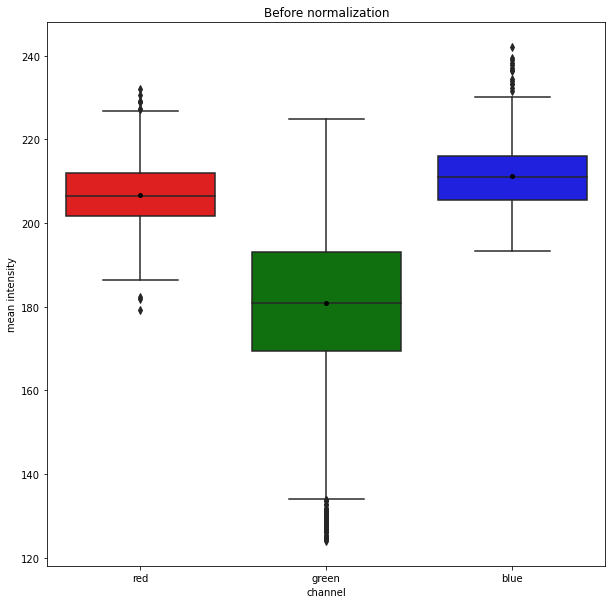

In [54]:
plt.figure(figsize=(10, 10))
rgb_pal = {"red": "r", "green": "g", "blue":"b"}
sns.boxplot(x=df['channel'], y=df['mean intensity'], palette=my_pal)
#sns.swarmplot(x=df['channel'], y=df['mean intensity'], palette=my_pal, edgecolor='black')
sns.swarmplot(x=df_template['channel'], y=df_template['mean intensity'], color='black', edgecolor='black')
plt.title('Before normalization')
plt.show()

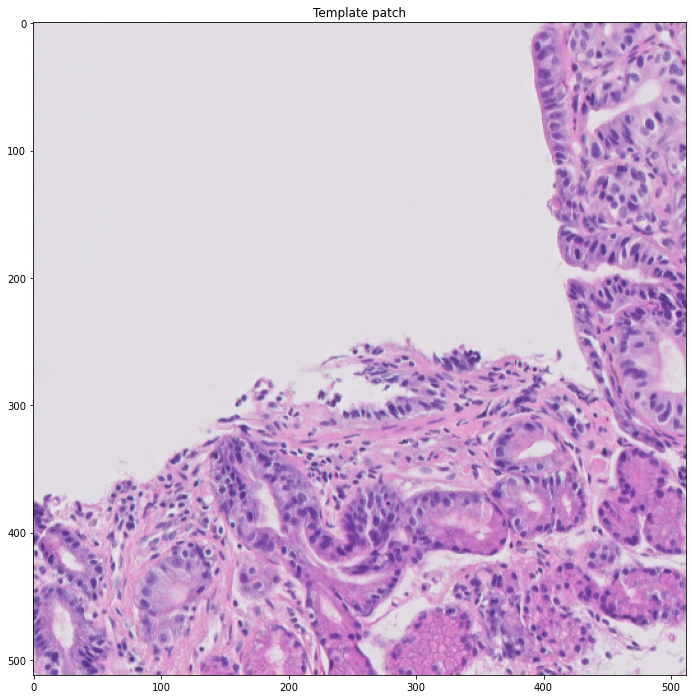

In [66]:
template_patch = patches[template_ind]
plt.figure(figsize=(12, 12))
plt.imshow(template_patch)
plt.title('Template patch')
plt.show()

In [97]:
# uint8
target = template_patch.astype('uint8')

# Standardize brightness (optional, can improve the tissue mask calculation)
target = staintools.LuminosityStandardizer.standardize(target)

# vahadane normalizer
normalizer = staintools.StainNormalizer(method='vahadane')
normalizer.fit(target)

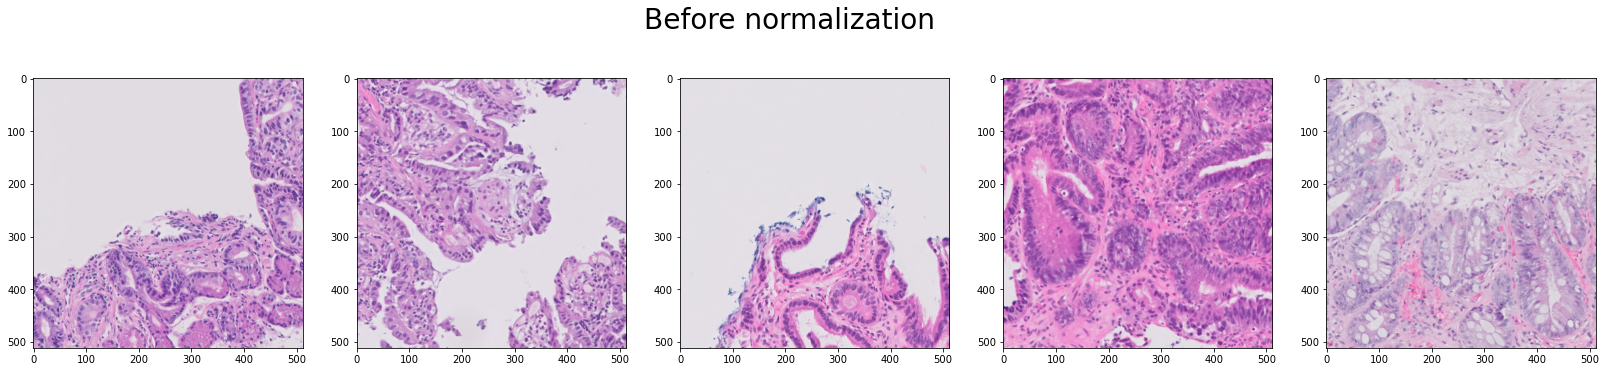

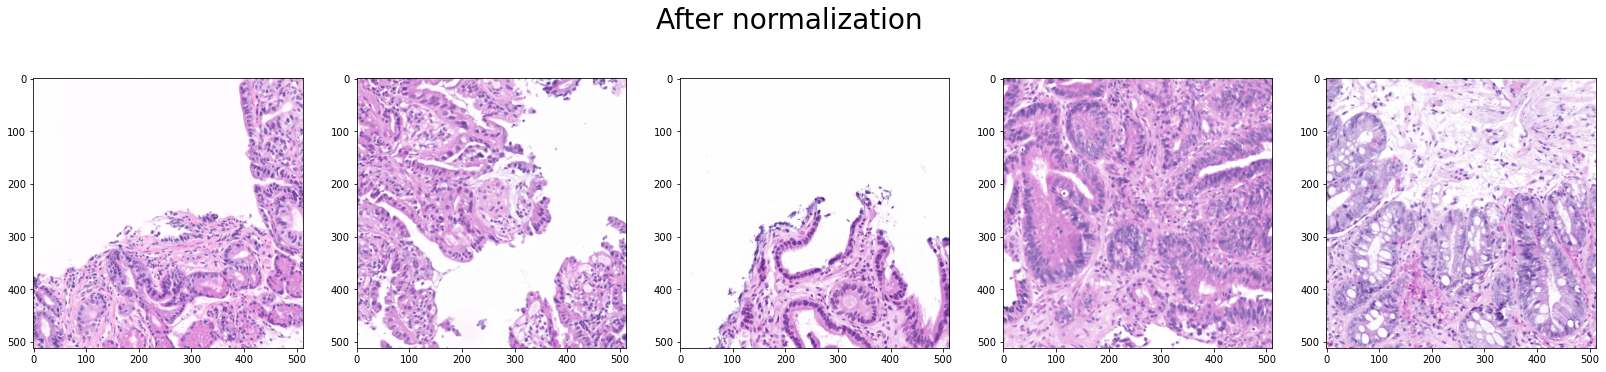

In [103]:
# select 4 random patches
before = [p.astype('uint8') for p in random.sample(patches, 4)]

after = []

for p in before:
    p = staintools.LuminosityStandardizer.standardize(p)
    p = normalizer.transform(p)
    after.append(p)


plt.figure(figsize=(28, 6))
for i, p in enumerate([template_patch] + before):
    plt.subplot(1, 5, i+1)
    plt.imshow(p)
plt.suptitle('Before normalization', fontsize=28)
plt.show()

plt.figure(figsize=(28, 6))
for i, p in enumerate([target] + after):
    plt.subplot(1, 5, i+1)
    plt.imshow(p)
plt.suptitle('After normalization', fontsize=28)
plt.show()